# Build Simulations

We're going to use this notebook to simulate data sets we'll use moving forward. We'll look at two main types of data: continous and categorical. 

In [1]:
import os
import pickle
import warnings

import numpy as np
import pandas as pd
import scipy.stats
import skbio
import seaborn as sn
import statsmodels.api as sm
import matplotlib.pyplot as plt

import emp_power.simulate as sim

% matplotlib inline
sn.set_style('ticks')

Let's also set this up to ignore certain warnings that appear due to dependent packages.

In [2]:
warnings.filterwarnings('ignore')

# Setting up the simulations

We'll set a random seed so the simulation results are consistent.

In [3]:
np.random.seed(25) 

The simulations will be saved in a directory under the current on called simulations. You can change this directory, but if you choose to do so, you'll need to update the directory in subsequent notebooks.

In [4]:
sim_location = './simulations/data/'
if not os.path.exists(sim_location):
    os.makedirs(sim_location)

We'll perform 100 simulations, and we'll track the information about the simulation in a dictonary called distribution.

In [5]:
num_rounds = 100
distributions = {}

## Helper Functions

We'll define a helper function which will allow us to easily retrieve functions associated with the simulation.

In [6]:
def retrieve_test(simulation_type):
    """The simulation function, test, and simulation parameters"""
    simulation = distributions[simulation_type]['function']
    test = distributions[simulation_type]['test']
    kwargs = distributions[simulation_type]['kwargs']
    
    return simulation, test, kwargs

We'll also define a function which will produce a pretty plot associated with the distribution.

In [7]:
def clean_up_axis(ax):
    """Formats the axis"""
    ax.set_yticks([])
    ax.set_yticklabels('')
    ax.set_xticklabels('')
    
    sn.despine(left=True, right=True, top=True, offset=10)

# Categorical Tests

## One Sample T test

We'll start by simulating data for a one sample t test. This test checks an observation is drawn from a sample. We are testing the alternatively hypotheses,

$\begin{matrix}
\textbf{H}_{0} & x = \bar{x} \\
\textbf{H}_{1} & x \neq \bar{x}\\
\end{matrix} \tag{2.1}$

It is assumed the sample is aspmotically normal.

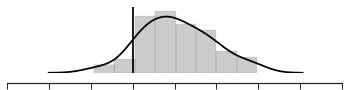

In [8]:
data = sim.simulate_ttest_1(mu_lim=[5, 6], sigma_lim=[4, 6], count_lim=[100, 101])
ax = plt.subplot(3, 1, 1)
sn.distplot(data[1], ax=ax, color='k', hist_kws={'alpha': 0.2})
ylim = ax.get_ylim()
ax.plot([0, 0], [0, 0.125], 'k-')
ax.set_ylim(ylim)
clean_up_axis(ax)

We'll simulate the data using a random normal distribution. The means for the distribution will be between 5 and 10, the standard deviations between 5 and 8, and the sample size between 60 and 100 observations.

In [9]:
distributions['ttest_1'] = {'function': sim.simulate_ttest_1,
                            'test': lambda x: scipy.stats.ttest_1samp(*x, 0),
                            'kwargs': {'mu_lim': [5, 10],
                                       'sigma_lim': [5, 8],
                                       'count_lim': [60, 100]}
                            }

## Two Sample Independent T test

We'll also simulate data for a two sample T test.

The case II t test is a test for two independent samples, to determine if the samples are drawn from different distributions.

$\begin{matrix}
\textbf{H}_{0} & \bar{x}_{1} = \bar{x}_{2} \\
\textbf{H}_{1} & \bar{x}_{1} \neq \bar{x}_{2}\\
\end{matrix} \tag{3.1}$

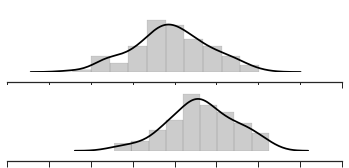

In [10]:
data = sim.simulate_ttest_ind(mu_lim=[0, 6], sigma_lim=[4, 6], count_lim=[100, 101])

ax1 = plt.subplot(3, 1, 1)
ax2 = plt.subplot(3, 1, 2, sharey=ax1, sharex=ax1)
sn.distplot(data[1][0], ax=ax1, color='k', hist_kws={'alpha': 0.2})
sn.distplot(data[1][1], ax=ax2, color='k', hist_kws={'alpha': 0.2})

ax1.set_ylim([0, 0.125])
ax2.set_ylim([0, 0.125])

clean_up_axis(ax1)
clean_up_axis(ax2)

We'll set up simulations with means between 0 and 10, with standard deviations between 5 and 15, and sample sizes between 60 and 100. The simulated distributions will have the same number of observations per sample, although this will vary between simulations.

In [11]:
distributions['ttest_ind'] = {'function': sim.simulate_ttest_ind,
                              'test': lambda x: scipy.stats.ttest_ind(*samples),
                              'kwargs': {'mu_lim': [0, 10],
                                         'sigma_lim': [5, 15],
                                         'count_lim': [60, 100]}
                              }

## One way ANOVA

A one-way Analysis of Variance (ANOVA) is typically  used to compare a set of multiple distributions ($n \geq 3$), to determine if one or more means are different. 

$\begin{matrix}
\textbf{H}_{0} & \bar{x}_{1} = \bar{x}_{2} = ... \bar{x}_{k} & \\
\textbf{H}_{1} & \bar{x}_{i} \neq \bar{x}_{j} & \exists i,j \epsilon [1, k], i \neq j
\end{matrix} \tag{4.2}$

We'll once again simulate normal distributions, to compare the data.

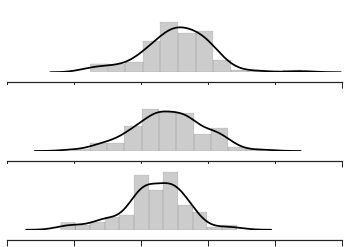

In [12]:
data = sim.simulate_anova(mu_lim=[0, 6], sigma_lim=[4, 6], count_lim=[100, 101], num_pops=3)

ax1 = plt.subplot(3, 1, 1)
ax2 = plt.subplot(3, 1, 2, sharey=ax1, sharex=ax1)
ax3 = plt.subplot(3, 1, 3, sharex=ax1, sharey=ax1)
sn.distplot(data[1][0], ax=ax1, color='k', hist_kws={'alpha': 0.2})
sn.distplot(data[1][1], ax=ax2, color='k', hist_kws={'alpha': 0.2})
sn.distplot(data[1][2], ax=ax3, color='k', hist_kws={'alpha': 0.2})

clean_up_axis(ax1)
clean_up_axis(ax2)
clean_up_axis(ax3)

We'll simulate two sets of distributions for ANOVA: a 3 sample and an 8 sample ANOVA. In both cases, we'll have means between 0 and 10, standard deviations between 5 and 15, and we'll once again have between 60 and 100 observations per sample, although the samples will be the same size.

In [13]:
distributions['anova_3'] = {'function': sim.simulate_anova,
                            'test': lambda x: scipy.stats.f_oneway(*x),
                            'kwargs': {'mu_lim': [0, 10],
                                       'sigma_lim': [5, 15],
                                       'count_lim': [60, 100],
                                       'num_pops': 3}
                            }
distributions['anova_8'] = {'function': sim.simulate_anova,
                            'test': lambda x: scipy.stats.f_oneway(*x),
                            'kwargs': {'mu_lim': [0, 10],
                                       'sigma_lim': [5, 15],
                                       'count_lim': [60, 100],
                                       'num_pops': 8}
                            }

## PERMANOVA on distance matrix

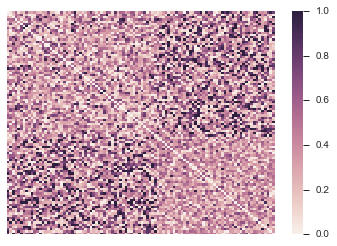

In [14]:
dm = sim.simulate_permanova(num_samples=100, 
                            wdist=[0, 0.4], 
                            wspread=[0.1, 0.4],
                            bdist=[0.25, 0.75],
                            bspread=[0.1, 0.6],
                           )[1][0]
ax = plt.axes()
sn.heatmap(dm.data, ax=ax)
ax.set_yticks([])
yt = ax.set_xticks([])

In [15]:
def permanova_test(samples):
    """Wraps the scikit-bio permanova for convenience"""
    [dm, groups] = samples
    res = skbio.stats.distance.permanova(dm,
                                         groups,
                                         permutations=99)
    return res['p-value']

In [16]:
distributions['permanova'] = {'function': sim.simulate_permanova,
                              'test': permanova_test,
                              'kwargs': {'num_samples': np.random.randint(120, 200),
                                         'num0': None,
                                         'wdist': [0.4, 0.6],
                                         'wspread': [0.3, 0.5], 
                                         'bdist': [0.45, 0.7],
                                         'bspread': [0.3, 0.6],
                                         }
                              }

# Continous Distributions

## Univariate Correlation

In [17]:
[s, n, m, b], [x, y] = sim.simulate_correlation([1, 5], [-2, 2], [25, 50], [100, 101], [-20, 20])

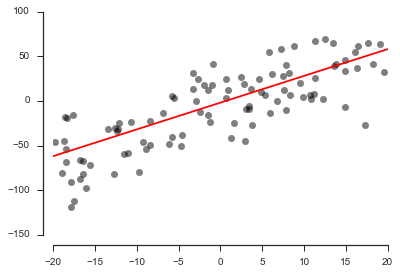

In [18]:
ax = plt.axes()
ax.plot(x, y, 'ko', alpha=0.5)
ax.plot(np.arange(-20, 21, 1), m * np.arange(-20, 21,) + b, 'r-')
ax.set_xlim
sn.despine(offset=10)

In [19]:
distributions['correlation'] = {'function': sim.simulate_correlation,
                                'test': lambda x: scipy.stats.pearsonr(*x),
                                'kwargs': {'slope_lim': [1, 5],
                                           'intercept_lim': [-2, 2],
                                           'sigma_lim': [25, 50],
                                           'count_lim': [60, 100],
                                           'x_lim': [-20, 20]}
                                 }

## Multivariate Correlation

In [20]:
[ms, b, s, n], [x, y] = sim.simulate_multivariate([-5, 5], [-3, 3], [3, 8], [100, 101], [-10, 10], 3)

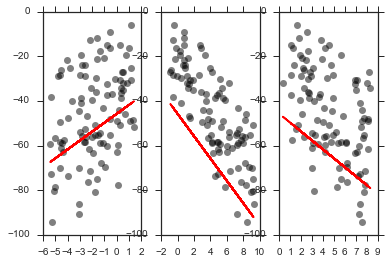

In [21]:
x1 = np.arange(np.floor(x[:, 0].min()), np.ceil(x[:, 0].max()), 1)
x2 = np.arange(np.floor(x[:, 1].min()), np.ceil(x[:, 1].max()), 1)
x3 = np.arange(np.floor(x[:, 2].min()), np.ceil(x[:, 2].max()), 1)

fig, axes = plt.subplots(1, 3)
axes[0].plot(x[:, 0], y, 'ko', alpha=0.5)
axes[0].plot(x[:, 0], ms[0] * x[:, 0] + y.mean(), 'r-')
axes[1].plot(x[:, 1], y, 'ko', alpha=0.5)
axes[1].plot(x[:, 1], ms[1] * x[:, 1] + y.mean(), 'r-')
axes[2].plot(x[:, 2], y, 'ko', alpha=0.5)
axes[2].plot(x[:, 2], ms[2] * x[:, 2] + y.mean(), 'r-')

In [22]:
def multivariate_test(samples):
    """Wraps the statsmodels Ordinary Least Squares model"""
    [xs, y] = samples
    r = sm.OLS(y, sm.add_constant(xs)).fit()
    return r.pvalues

In [23]:
distributions['multivariate'] = {'function': sim.simulate_multivariate,
                                'test': multivariate_test,
                                'kwargs': {'slope_lim': [-5, 5],
                                           'intercept_lim': [-3, 3],
                                           'sigma_lim': [3, 8],
                                           'count_lim': [60, 100],
                                           'x_lim': [-10, 10],
                                           'num_pops': 2,
                                           }
                                }

## Distance Correlation

In [24]:
p, [x, y] = sim.simulate_mantel([1, 5], [-2, 2], [2, 10], [100, 101], x_lim=[-10, 10])

In [25]:
x_prime = pd.DataFrame(x.data, index=x.ids, columns=x.ids)
x_order = x_prime.sort_values('s.1').index

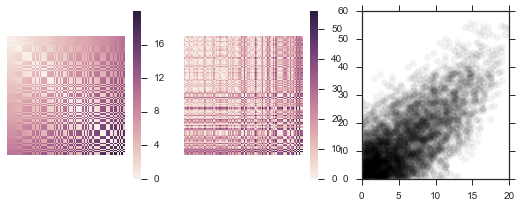

In [26]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3)
fig.set_size_inches(9, 3)
sn.heatmap(x.filter(x_order).data, ax=ax1)
sn.heatmap(y.filter(x_order).data, ax=ax2)
ax1.axis('equal')
ax1.set_xticks([])
ax1.set_yticks([])
ax2.axis('equal')
ax2.set_xticks([])
ax2.set_yticks([])
ax3.plot(x.condensed_form(), y.condensed_form(), 'ko', alpha=0.05)

In [27]:
def mantel_test(samples):
    """Wraps the scikit-bio mantel test"""
    [x, y] = samples
    return skbio.stats.distance.mantel(x, y, 
                                       method='spearman', 
                                       permutations=99)[1]

In [28]:
distributions['mantel'] = {'function': sim.simulate_mantel,
                           'test': mantel_test,
                           'kwargs': {'slope_lim': [1, 5],
                                      'intercept_lim': [-2, 2],
                                      'sigma_lim': [2, 10],
                                      'count_lim': [60, 100],
                                      'x_lim': [-10, 10],
                                      }
                           }

# Simulates the data

In [29]:
for test_name in distributions.keys():
    # Gets the simulation function, test, and arguments
    simulation, test, kwargs = retrieve_test(test_name)
    if not os.path.exists(os.path.join(sim_location, test_name)):
        os.makedirs(os.path.join(sim_location, test_name))
    # Permforms the simulations
    for i in range(num_rounds):
        file = os.path.join(sim_location, '%s/simulation_%i.p' % (test_name, i))
        params, samples = simulation(**kwargs)
        p = test(samples)
        with open(file, 'wb') as f_:
            pickle.dump({'samples': samples, 'params': params, 'p_value': p}, f_)

We can now use the simulated data to explore power benchmarking.